In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import timm

from sklearn.model_selection import train_test_split

from PIL import Image, ImageOps
from transformers import ViTFeatureExtractor, ViTForImageClassification

from memory_profiler import memory_usage
import random
import gc
from astropy.io import fits

from skimage import io
import matplotlib.pyplot as plt
#If using script on terminal
#import tqdm
from tqdm.notebook import tqdm

from astropy.visualization import make_lupton_rgb
plt.style.use('dark_background')

In [2]:
class ImageDataset(Dataset):
    """Dataset of Images, Data and Labels"""

    def __init__(self, images, data, labels, transform=None):
        """
        Create a PyTorch dataset from an array of images
		and an array of labels
        """
        super().__init__()
        self.images = images
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        #return python image given the index
        image = self.images[idx]
        """
        #Plotting with Astropy and saving as png (not used right now)
        print('Astropy')
        rgb = make_lupton_rgb(image[2], image[1], image[0], Q=11., stretch=40.)
        plt.imshow(rgb, aspect='equal')
        plt.savefig('Image.png', bbox_inches='tight')
        plt.close()
        new_image = Image.open('Image.png')
        return(new_image)
        """
        new_image = np.empty((3, 46, 46))
        new_image[0], new_image[1], new_image[2] =  self.normalize_image(image)
        new_image = new_image.transpose(1,2,0)
        new_image = Image.fromarray(np.uint8(255*new_image)).convert("RGB")
        label = self.labels[idx]
        data_point = self.data.iloc[idx].to_dict()
        sample = {'image': self.transform(new_image), 'label': label, 'img': image, 'data': data_point}
        return sample
    
    def normalize_image(self, image):
        image_g = (image[0]-np.mean(image[0]))/ np.std(image[0])
        image_r = (image[1]-np.mean(image[1]))/ np.std(image[1])
        image_i = (image[2]-np.mean(image[2]))/ np.std(image[2])

        image_g = (image_g-np.min(image_g))/ (np.max(image_g) - np.min(image_g))
        image_r = (image_r-np.min(image_r))/ (np.max(image_r) - np.min(image_r))
        image_i = (image_i-np.min(image_i))/ (np.max(image_i) - np.min(image_i))
        return(image_i, image_r, image_g)
    
    def plot_image(self, idx):
        image = images[idx]
        new_image = np.empty((3, 46, 46))
        new_image[0], new_image[1], new_image[2] =  self.normalize_image(image)
        new_image = new_image.transpose(1,2,0)
        new_image = Image.fromarray(np.uint8(255*new_image)).convert("RGB")
        
        plt.figure(figsize=(12,4)) 
        
        plt.subplot(1,2,1)
        plt.imshow(np.asarray(new_image))
        plt.axis('off')
        
        plt.subplot(1,2,2)
        rgb = make_lupton_rgb(image[2], image[1], image[0], Q=11., stretch=40.)
        plt.imshow(rgb, aspect='equal')
        plt.axis('off')
        
        plt.show()

In [3]:
def make_train_test_datasets(images, data, labels, test_size=0.2, transform=None):
    """
	Make training and testing datasets
	
	Args:
	    images: 3D array of all images
        labels: 1D array of the labels for each image
        test_size: the fraction of the images to use as the test dataset
		transform: the PyTorch transformation to apply to the data
		
	Returns
	    train_dataset: An instance of the ImageDataset Class for training
		test_dataset: An instance of the ImageDataset Class for testing
	"""

    # Shuffle and split data
    y = labels
    train_images, test_images, train_data, test_data, train_labels, test_labels = train_test_split(
        images, data, labels, test_size=test_size, random_state=6, stratify=y)
    
    # Create a PyTorch Dataset
    return (ImageDataset(train_images, train_data, train_labels, transform=transform),
            ImageDataset(test_images, test_data, test_labels, transform=transform))

In [4]:
num_pos, num_neg = 200, 200
path = '/Users/jimenagonzalez/research/DSPL/Simulations-Double-Source-Gravitational-Lensing/Data/Sim_complete/'

hdu_list = fits.open(path + 'exp/34.fits')
idx = random.sample(range(len(hdu_list[1].data)), num_pos)
images_pos = hdu_list[1].data[idx,:] 
data_pos = pd.DataFrame(hdu_list[2].data[:][idx])
labels_pos = np.zeros(num_pos, dtype = np.int64)

hdu_list = fits.open(path + 'negative_cases.fits')
idx = random.sample(range(len(hdu_list[1].data)), num_neg)
images_neg = hdu_list[1].data[idx,:] 
labels_neg = np.ones(num_neg, dtype = np.int64)
#Data for negatives, all null
num_columns = len(data_pos.columns)
data_neg = np.full((num_neg, num_columns-1), 0)
data_neg = pd.DataFrame(data_neg, columns=['zl/z1', 'm', 'iso', 'E', 'Magni 1'])
last_column = ['NEG']*num_neg
data_neg['ID'] = last_column

images_dataset = np.concatenate((images_pos, images_neg)).astype(np.float32)
data_dataset = pd.concat([data_pos, data_neg], axis=0).reset_index(drop=True)
labels_dataset = np.concatenate((labels_pos,labels_neg), dtype = np.int64)

transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

5085


In [5]:
train_dataset, test_dataset = make_train_test_datasets(images_dataset, data_dataset, labels_dataset, test_size=0.2, transform=transform)
print('Len train dataset: {}, len test dataset: {}'.format(len(train_dataset), len(test_dataset)))

Len train dataset: 320, len test dataset: 80


In [8]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=20, num_workers=0, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=20, num_workers=0, shuffle=True)

In [10]:
model = timm.create_model("vit_base_patch16_224", pretrained=True)
path = 'jx_vit_base_p16_224-80ecf9dd.pth'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [11]:
class ViTBase16(nn.Module):
    
    def __init__(self, n_classes, pretrained=False):
        
        super(ViTBase16, self).__init__()
        
        self.model = timm.create_model("vit_base_patch16_224", pretrained=True)
        if (pretrained):
            path = 'jx_vit_base_p16_224-80ecf9dd.pth'
            self.model.load_state_dict(torch.load(path))

        self.model.head = nn.Linear(self.model.head.in_features, n_classes)

    def forward(self, x):

        x = self.model(x)

        return x

    def train_one_epoch(self, train_loader, criterion, optimizer, device):
        # keep track of training loss
        epoch_loss = 0.0
        epoch_accuracy = 0.0

        ###################
        # train the model #
        ###################

        self.model.train()

        #for i, (data, target, sample_img, sample_data) in tqdm(enumerate(train_loader)):
        for i, sample in enumerate(tqdm(train_loader)):

            data, target, sample_img, sample_data = sample['image'], sample['label'] , sample['img'], sample['data']
            
            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = self.forward(data)
            #output = torch.squeeze(output)

            #target = target.float()
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            
            # Calculate Accuracy
            #accuracy = (output.argmax(dim=1) == target).float().mean()
            accuracy = sum(output.argmax(dim=1) == target)
            print(accuracy)
            # update training loss and accuracy
            epoch_loss += loss
            epoch_accuracy += accuracy

            optimizer.step()

        return epoch_loss / len(train_loader.dataset), epoch_accuracy / len(train_loader.dataset)

    def validate_one_epoch(self, valid_loader, criterion, device):
        # keep track of validation loss
        valid_loss = 0.0
        valid_accuracy = 0.0

        ######################
        # validate the model #
        ######################
        self.model.eval()
        for i, sample in enumerate(tqdm(valid_loader)):
            data, target, sample_img, sample_data = sample['image'], sample['label'] , sample['img'], sample['data']
            
            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()

            with torch.no_grad():
                # forward pass: compute predicted outputs by passing inputs to the model
                output = self.model(data)
                # calculate the batch loss
                loss = criterion(output, target)
                # Calculate Accuracy
                #accuracy = (output.argmax(dim=1) == target).float().mean()
                accuracy = sum(output.argmax(dim=1) == target)
                print(accuracy)
                # update average validation loss and accuracy
                valid_loss += loss
                valid_accuracy += accuracy

        return valid_loss / len(valid_loader.dataset), valid_accuracy / len(valid_loader.dataset)

In [12]:
model = ViTBase16(n_classes=2, pretrained=True)

# Start training processes
device = torch.device("cuda")

criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

cpu


In [13]:
def fit_tpu(model, name_model, epochs, device, criterion, optimizer, train_loader, valid_loader=None):
    
    best_val_acc = 0.0 # track of best accuracy

    # keeping track of losses as it happen
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []

    for epoch in range(1, epochs + 1):
        gc.collect()
        
        print(f"{'=' * 100}")
        print(f"EPOCH {epoch} - TRAINING...")
        train_loss, train_acc = model.train_one_epoch(train_loader, criterion, optimizer, device)
        print(f"\n\t[TRAIN] EPOCH {epoch} - LOSS: {train_loss}, ACCURACY: {train_acc}\n")
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        gc.collect()

        # moves towards valid_loader
        print("start valid_loader")

        if valid_loader is not None:
            gc.collect()
            print(f"EPOCH {epoch} - VALIDATING...")
            valid_loss, valid_acc = model.validate_one_epoch(valid_loader, criterion, device)
            print(f"\t[VALID] LOSS: {valid_loss}, ACCURACY: {valid_acc}\n")
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)
            gc.collect()

            if(valid_acc > best_val_acc):
                setattr(model, 'loss_train', train_losses)
                setattr(model, 'loss_valid', valid_losses)
                setattr(model, 'train_acc', train_accs)
                setattr(model, 'validation_acc', valid_accs)
                torch.save(model, name_model)
                best_val_acc = valid_acc
    """
    return {
        "train_loss": train_losses,
        "valid_losses": valid_losses,
        "train_acc": train_accs,
        "valid_acc": valid_accs,
    }"""

In [14]:
def plot_performance(cnn):
    loss_train = [x.item() for x in cnn.loss_train]
    loss_valid = [x.item() for x in cnn.loss_valid]
    train_acc = [x.item() for x in cnn.train_acc]
    valid_acc = [x.item() for x in cnn.validation_acc]
    
    x = np.linspace(1,len(cnn.loss_train),len(cnn.loss_train))
    fig, (ax1, ax2) = plt.subplots(figsize=(16, 7), ncols=2)
    
    ax1.set_title('Losses')
    ax1.set_xlabel('Epoch')
    ax1.scatter(x, loss_train, color = 'skyblue', alpha = 0.8, label = 'Training loss')
    ax1.scatter(x, loss_valid, color = 'limegreen', alpha = 0.8,  label = 'Validation loss')
    ax1.legend()
    
    ax2.set_title('Performance. Max: {:.4f}%'.format(cnn.validation_acc[-1].item()))
    ax2.set_xlabel('Epoch')
    ax2.scatter(x, train_acc, color = 'skyblue', alpha = 0.8,  label = 'Training Accuracy')
    ax2.scatter(x, valid_acc, color = 'limegreen', alpha = 0.8,  label = 'Validation Accuracy')
    ax2.legend()
    
    #plt.savefig('Performance.png', bbox_inches='tight')
    plt.show(block=True)

In [15]:
#print(len(train_dataset), len(test_dataset))
name_model = 'other.pt'
#                          model, name_model, epochs, device, criterion, optimizer, train_loader, valid_loader=None
mem_usage = memory_usage(( fit_tpu, (model, name_model, 1, device, criterion, optimizer, train_loader, test_loader)))

#fit_tpu(model=model, name_model=name_model, epochs=5, device=device, 
#        criterion=criterion, optimizer=optimizer, train_loader=train_loader, valid_loader=test_loader)


EPOCH 1 - TRAINING...
[0 1 1 0 1 1 1 1 1 1 0 1 0 0 0 0 1 1 0 0 1 1 1 0 0 1 1 0 0 0 0 1 1 1 0 1 0
 1 0 1 0 0 0 1 1 1 0 0 0 1 1 0 0 1 1 1 0 1 0 1 1 1 1 0 1 0 0 1 1 1 0 0 1 1
 0 1 0 0 1 1 1 0 1 0 1 0 1 0 1 1 1 0 1 0 0 0 1 1 1 1 0 1 0 1 0 0 1 1 0 1 0
 1 1 1 0 1 1 0 1 0 1 0 0 0 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 0 1 1 0 1
 0 1 0 1 1 0 1 0 1 0 0 0 0 0 0 1 0 1 1 1 0 1 1 1 0 1 0 1 0 1 1 1 1 0 0 0 1
 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 1 1 1 0 1 0 0 0 1 1 1 0 0 0 0 0 0 1
 1 0 1 1 0 1 1 1 0 0 1 0 1 0 1 0 1 1 1 0 0 1 0 0 0 1 0 1 0 0 1 1 0 1 1 1 0
 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0
 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 1 1 1 1]
        zl/z1          m       iso         E   Magni 1               ID
145  0.774478  21.724288  0.503094  1.191987  8.902568  POS_267555037_0
346  0.000000   0.000000  0.000000  0.000000  0.000000              NEG
290  0.000000   0.000000  0.000000  0.000000  0.000000              NEG
53   0.590042  23.044355  0.805995  1.48

  0%|          | 0/16 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0])
tensor([1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1])
tensor(8)
tensor([0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor(13)
tensor([1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor(11)
tensor([0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor(11)
tensor([1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1])
tensor(8)
tensor([1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor(11)
tensor([1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

  0%|          | 0/4 [00:00<?, ?it/s]

tensor([1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1])
tensor([1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1])
{'zl/z1': tensor([0.0000, 0.4534, 0.4611, 0.0000, 0.0000, 0.5679, 0.4611, 0.7192, 0.5869,
        0.4424, 0.0000, 0.5104, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5609,
        0.5293, 0.0000], dtype=torch.float64), 'm': tensor([ 0.0000, 21.0377, 21.8119,  0.0000,  0.0000, 21.4281, 21.4964, 23.8285,
        22.4556, 21.6223,  0.0000, 21.9705,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000, 22.1167, 22.5112,  0.0000], dtype=torch.float64), 'iso': tensor([0.0000, 0.5592, 0.4079, 0.0000, 0.0000, 0.5627, 0.4683, 0.9311, 0.3870,
        0.4268, 0.0000, 0.5148, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3542,
        0.8035, 0.0000], dtype=torch.float64), 'E': tensor([0.0000, 2.1239, 2.0290, 0.0000, 0.0000, 1.6272, 2.0489, 0.8368, 1.5864,
        2.2988, 0.0000, 2.1568, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.2243,
        1.2440, 0.0000], dtype=tor

  0%|          | 0/16 [00:00<?, ?it/s]

tensor([1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1])
tensor([1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1])
tensor(20)
tensor([1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1])
tensor(8)
tensor([0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1])
tensor([1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1])
tensor(15)
tensor([1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0])
tensor([1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0])
tensor(18)
tensor([1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0])
tensor(13)
tensor([0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0])
tensor([1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0])
tensor(15)
tensor([1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0])
tensor([1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 

  0%|          | 0/4 [00:00<?, ?it/s]

tensor([1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1])
tensor([1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1])
{'zl/z1': tensor([0.0000, 0.0000, 0.5465, 0.5104, 0.1856, 0.0000, 0.0000, 0.6147, 0.4611,
        0.4424, 0.8046, 0.8698, 0.0000, 0.0000, 0.7729, 0.0000, 0.4952, 0.0000,
        0.5293, 0.0000], dtype=torch.float64), 'm': tensor([ 0.0000,  0.0000, 23.3143, 21.9705, 23.7742,  0.0000,  0.0000, 21.3651,
        21.4964, 21.6223, 21.9848, 21.7417,  0.0000,  0.0000, 22.0472,  0.0000,
        21.3878,  0.0000, 22.5112,  0.0000], dtype=torch.float64), 'iso': tensor([0.0000, 0.0000, 0.5288, 0.5148, 0.5491, 0.0000, 0.0000, 0.6955, 0.4683,
        0.4268, 0.4354, 0.4574, 0.0000, 0.0000, 0.3924, 0.0000, 0.3767, 0.0000,
        0.8035, 0.0000], dtype=torch.float64), 'E': tensor([0.0000, 0.0000, 1.4570, 2.1568, 2.4282, 0.0000, 0.0000, 1.9490, 2.0489,
        2.2988, 0.7212, 0.4326, 0.0000, 0.0000, 0.8632, 0.0000, 2.0749, 0.0000,
        1.2440, 0.0000], dtype=tor

  0%|          | 0/16 [00:00<?, ?it/s]

tensor([0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1])
tensor([0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1])
tensor(16)
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0])
tensor(18)
tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0])
tensor([1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0])
tensor(13)
tensor([0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1])
tensor([0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1])
tensor(19)
tensor([1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0])
tensor([1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0])
tensor(19)
tensor([1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0])
tensor([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0])
tensor(15)
tensor([0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0])
tensor([0, 0, 1, 0, 1, 0, 1, 0, 0, 1,

  0%|          | 0/4 [00:00<?, ?it/s]

tensor([1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0])
tensor([1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1])
{'zl/z1': tensor([0.0000, 0.3484, 0.5869, 0.5884, 0.0000, 0.0000, 0.7729, 0.0000, 0.8141,
        0.0000, 0.0000, 0.0000, 0.5070, 0.0000, 0.4611, 0.0000, 0.0000, 0.4603,
        0.0000, 0.5609], dtype=torch.float64), 'm': tensor([ 0.0000, 20.9364, 22.4556, 20.4272,  0.0000,  0.0000, 22.0472,  0.0000,
        21.6678,  0.0000,  0.0000,  0.0000, 22.9940,  0.0000, 21.8119,  0.0000,
         0.0000, 22.9721,  0.0000, 22.1167], dtype=torch.float64), 'iso': tensor([0.0000, 0.3578, 0.3870, 0.4580, 0.0000, 0.0000, 0.3924, 0.0000, 0.4488,
        0.0000, 0.0000, 0.0000, 0.4052, 0.0000, 0.4079, 0.0000, 0.0000, 0.4447,
        0.0000, 0.3542], dtype=torch.float64), 'E': tensor([0.0000, 2.1512, 1.5864, 1.6118, 0.0000, 0.0000, 0.8632, 0.0000, 0.4565,
        0.0000, 0.0000, 0.0000, 1.5903, 0.0000, 2.0290, 0.0000, 0.0000, 2.4144,
        0.0000, 1.2243], dtype=tor

  0%|          | 0/16 [00:00<?, ?it/s]

tensor([0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0])
tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor(14)
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0])
tensor(18)
tensor([1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1])
tensor(18)
tensor([1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1])
tensor([0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1])
tensor(17)
tensor([0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0])
tensor([0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1])
tensor(16)
tensor([1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0])
tensor([1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1])
tensor(17)
tensor([0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1])
tensor([0, 0, 1, 0, 1, 0, 0, 0, 0, 1,

  0%|          | 0/4 [00:00<?, ?it/s]

tensor([0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0])
tensor([0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0])
{'zl/z1': tensor([0.5070, 0.0000, 0.0000, 0.1856, 0.0000, 0.0000, 0.5125, 0.0000, 0.0000,
        0.5104, 0.0000, 0.0000, 0.2671, 0.0000, 0.0000, 0.5679, 0.0000, 0.4534,
        0.0000, 0.4479], dtype=torch.float64), 'm': tensor([22.9940,  0.0000,  0.0000, 23.7742,  0.0000,  0.0000, 21.7030,  0.0000,
         0.0000, 21.9705,  0.0000,  0.0000, 21.0430,  0.0000,  0.0000, 21.4281,
         0.0000, 21.0377,  0.0000, 22.3666], dtype=torch.float64), 'iso': tensor([0.4052, 0.0000, 0.0000, 0.5491, 0.0000, 0.0000, 0.5072, 0.0000, 0.0000,
        0.5148, 0.0000, 0.0000, 0.5600, 0.0000, 0.0000, 0.5627, 0.0000, 0.5592,
        0.0000, 0.6141], dtype=torch.float64), 'E': tensor([1.5903, 0.0000, 0.0000, 2.4282, 0.0000, 0.0000, 1.6808, 0.0000, 0.0000,
        2.1568, 0.0000, 0.0000, 3.0367, 0.0000, 0.0000, 1.6272, 0.0000, 2.1239,
        0.0000, 2.2253], dtype=tor

  0%|          | 0/16 [00:00<?, ?it/s]

tensor([1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0])
tensor([1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1])
tensor(15)
tensor([1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0])
tensor([1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0])
tensor(18)
tensor([1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1])
tensor([1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1])
tensor(18)
tensor([1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1])
tensor([1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1])
tensor(18)
tensor([0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1])
tensor([1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1])
tensor(16)
tensor([1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1])
tensor([1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1])
tensor(20)
tensor([1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1])
tensor([1, 1, 0, 0, 0, 0, 0, 1, 0, 0,

  0%|          | 0/4 [00:00<?, ?it/s]

tensor([0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1])
tensor([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
{'zl/z1': tensor([0.5966, 0.4603, 0.6217, 0.0000, 0.6147, 0.0000, 0.8046, 0.5884, 0.5125,
        0.5070, 0.4706, 0.4611, 0.0000, 0.0000, 0.3484, 0.7046, 0.0000, 0.8141,
        0.0000, 0.0000], dtype=torch.float64), 'm': tensor([21.8407, 22.9721, 20.9519,  0.0000, 21.3651,  0.0000, 21.9848, 20.4272,
        21.7030, 22.9940, 22.4004, 21.4964,  0.0000,  0.0000, 20.9364, 19.4218,
         0.0000, 21.6678,  0.0000,  0.0000], dtype=torch.float64), 'iso': tensor([0.4076, 0.4447, 0.5673, 0.0000, 0.6955, 0.0000, 0.4354, 0.4580, 0.5072,
        0.4052, 0.8994, 0.4683, 0.0000, 0.0000, 0.3578, 0.5248, 0.0000, 0.4488,
        0.0000, 0.0000], dtype=torch.float64), 'E': tensor([1.6157, 2.4144, 1.2216, 0.0000, 1.9490, 0.0000, 0.7212, 1.6118, 1.6808,
        1.5903, 1.1973, 2.0489, 0.0000, 0.0000, 2.1512, 1.5591, 0.0000, 0.4565,
        0.0000, 0.0000], dtype=tor

In [16]:
print('Maximum memory usage: %s' % max(mem_usage))

In [17]:
name = 'other.pt'#'model.pt'#'other.pt' 
model_test = torch.load(name)
print('Maximum validation accuracy: {:.2f}%'.format(100*model_test.validation_acc[-1].item()))

Maximum validation accuracy: 80.00%


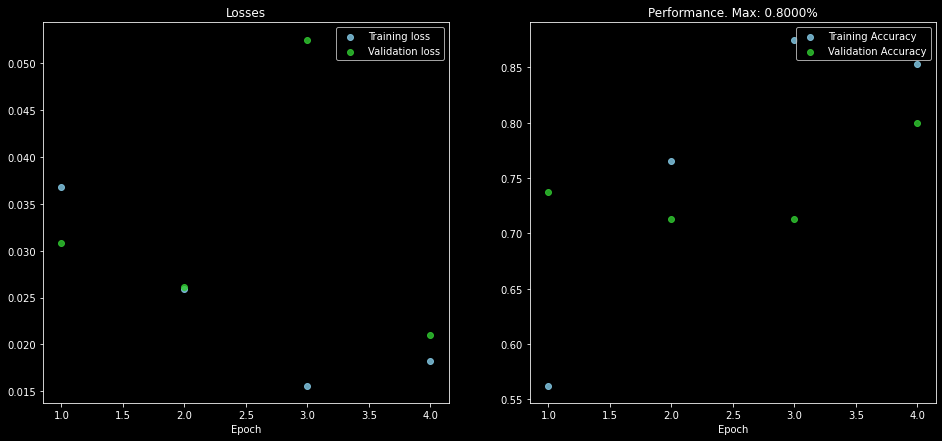

In [18]:
plot_performance(model_test)

In [19]:
new_test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, num_workers=0, shuffle=True)

80


In [20]:
model = model_test
right_pos_img, wrong_pos_img = np.zeros((1,3,46,46)), np.zeros((1,3,46,46))
right_neg_img, wrong_neg_img = np.zeros((1,3,46,46)), np.zeros((1,3,46,46))
columns = ['zl/z1', 'm', 'iso', 'E', 'Magni 1', 'ID', 'Prob']
prob_list = []
right_pos, wrong_pos = pd.DataFrame(columns=columns), pd.DataFrame(columns=columns)
right_neg, wrong_neg = pd.DataFrame(columns=columns), pd.DataFrame(columns=columns)

for i_batch, sample in enumerate(tqdm(new_test_loader)):
    sample_image, sample_label, sample_img, sample_data = sample['image'], sample['label'] , sample['img'], sample['data']
    
    #if(i_batch <= 50): continue
    output = model(sample_image)
    predicted = output.argmax(dim=1)
    my_df = pd.DataFrame.from_dict(sample_data)
    
    print(sample_label, predicted)
    
    prob = nn.Softmax(dim=1)(output)
    prob = prob[:,0].detach().numpy()[0]
    prob_list.append(prob)
    
    new_df = pd.DataFrame.from_dict(sample_data)
    new_df['Prob'] = prob
    
    if(sample_label.item() == 0 and predicted.item() == 0):
        right_pos_img = np.append(right_pos_img, [np.array(sample_img[0])], axis = 0)
        right_pos = right_pos.append(new_df, ignore_index=True)
    elif(sample_label.item() == 0 and predicted.item() == 1):
        wrong_pos_img = np.append(wrong_pos_img, [np.array(sample_img[0])], axis = 0)
        wrong_pos = wrong_pos.append(new_df, ignore_index=True)
    if(sample_label.item() == 1 and predicted.item() == 1): 
        right_neg_img = np.append(right_neg_img, [np.array(sample_img[0])], axis = 0)
        right_neg = right_neg.append(new_df, ignore_index=True)
    elif(sample_label.item() == 1 and predicted.item() == 0): 
        wrong_neg_img = np.append(wrong_neg_img, [np.array(sample_img[0])], axis = 0)
        wrong_neg = wrong_neg.append(new_df, ignore_index=True)
    
    
right_pos_img = np.delete(right_pos_img, 0, axis = 0)
wrong_pos_img = np.delete(wrong_pos_img, 0, axis = 0)
right_neg_img = np.delete(right_neg_img, 0, axis = 0)
wrong_neg_img = np.delete(wrong_neg_img, 0, axis = 0)

[0 1 0 0 1 1 0 1 1 0 0 0 1 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 0 1 1 1 1 0 1 1 0
 1 0 1 0 1 0 1 1 1 0 0 0 1 1 1 0 0 1 1 0 0 1 1 0 0 1 1 1 0 0 0 0 0 0 1 0 0
 1 0 0 1 1 1]
        zl/z1          m       iso         E    Magni 1               ID
57   0.594077  22.418899  0.362729  1.485750   8.376624  POS_301480115_0
291  0.000000   0.000000  0.000000  0.000000   0.000000              NEG
147  0.440206  20.115039  0.509898  1.906700   7.879594  POS_351093921_0
15   0.461106  21.496411  0.468255  2.048949   8.711779  POS_247308035_0
202  0.000000   0.000000  0.000000  0.000000   0.000000              NEG
..        ...        ...       ...       ...        ...              ...
127  0.470620  22.400383  0.899449  1.197274   4.256405   POS_61506657_0
77   0.442414  21.622291  0.426817  2.298810  13.585099  POS_279349095_0
214  0.000000   0.000000  0.000000  0.000000   0.000000              NEG
385  0.000000   0.000000  0.000000  0.000000   0.000000              NEG
297  0.000000   0.000000  0.00000

  0%|          | 0/80 [00:00<?, ?it/s]

tensor([1]) tensor([0])
['NEG']
tensor([1]) tensor([1])
['NEG']
tensor([0]) tensor([1])
['POS_61506657_0']
tensor([0]) tensor([1])
['POS_318126533_0']
tensor([1]) tensor([0])
['NEG']
tensor([0]) tensor([0])
['POS_279349095_0']
tensor([0]) tensor([0])
['POS_110125059_0']
tensor([0]) tensor([0])
['POS_218674524_0']
tensor([1]) tensor([0])
['NEG']
tensor([0]) tensor([1])
['POS_229814505_0']
tensor([1]) tensor([0])
['NEG']
tensor([1]) tensor([1])
['NEG']
tensor([1]) tensor([1])
['NEG']
tensor([0]) tensor([0])
['POS_277206176_0']
tensor([0]) tensor([0])
['POS_179071246_0']
tensor([1]) tensor([1])
['NEG']
tensor([1]) tensor([1])
['NEG']
tensor([0]) tensor([0])
['POS_319539519_0']
tensor([0]) tensor([0])
['POS_267353294_0']
tensor([1]) tensor([1])
['NEG']
tensor([0]) tensor([0])
['POS_247308035_0']
tensor([1]) tensor([1])
['NEG']
tensor([0]) tensor([0])
['POS_173232062_0']
tensor([0]) tensor([0])
['POS_279043494_0']
tensor([0]) tensor([0])
['POS_144670259_0']
tensor([0]) tensor([0])
['POS_351

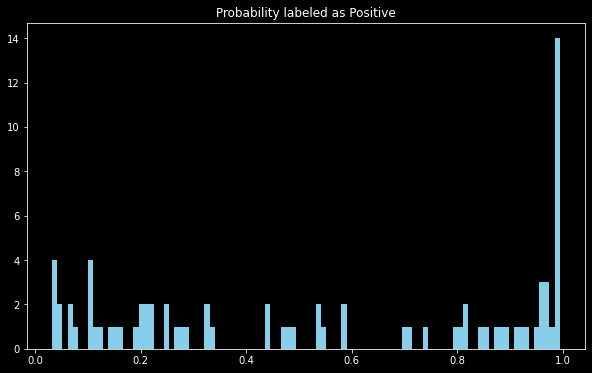

In [22]:
plt.figure(figsize=(10,6))
plt.title('Probability labeled as Positive')
plt.hist(prob_list, 100, color = "skyblue")
#plt.savefig(path_im + '/' + 'Prob_Pos Distribution.png', bbox_inches='tight')
plt.show()

In [23]:
print(right_pos_img.shape)
print(wrong_pos_img.shape)
print(right_neg_img.shape)
print(wrong_neg_img.shape)

(33, 3, 46, 46)
(7, 3, 46, 46)
(31, 3, 46, 46)
(9, 3, 46, 46)


In [24]:
print(np.mean(wrong_neg['Prob']))
print(np.mean(right_pos['Prob']))
print(np.mean(wrong_pos['Prob']))
print(np.mean(right_neg['Prob']))

0.7466930747032166
0.9131168723106384
0.27185875177383423
0.1847062110900879


In [25]:
def make_plot_all(objects, title, prob_list):
    print(title)
    for i in range(len(objects)):
        if(i%4 == 0):
            plt.figure(figsize=(12,8))
            for j in range(4):
                if(i+j > len(objects)-1): break
                plt.subplot(1,4,j+1)
                plt.title(prob_list[i+j])
                rgb = make_lupton_rgb(objects[i+j][2], objects[i+j][1], objects[i+j][0], Q=11., stretch=40.)
                plt.imshow(rgb, aspect='equal')
                plt.xticks([], [])
                plt.yticks([], []) 
            plt.show() 

Wrong negatives


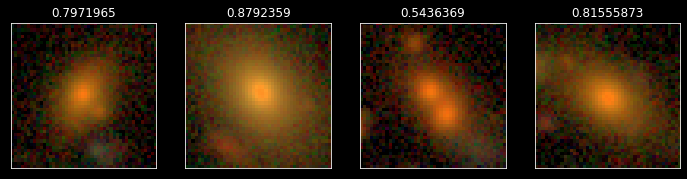

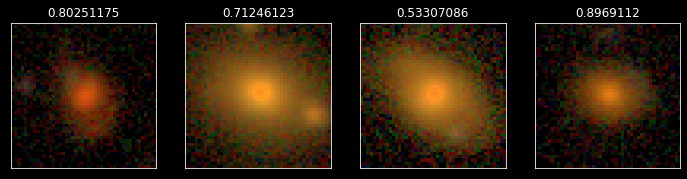

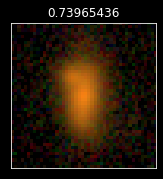

In [26]:
make_plot_all(wrong_neg_img, 'Wrong negatives', wrong_neg['Prob'])

Wrong positives


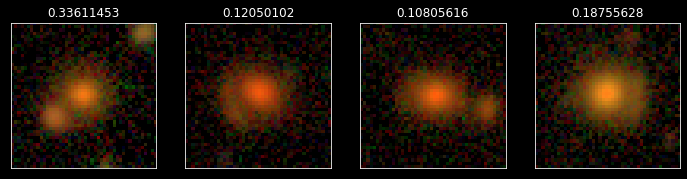

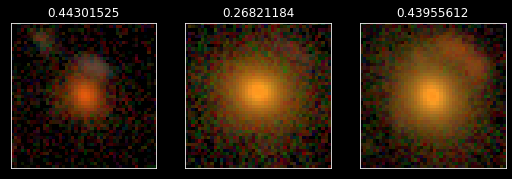

In [27]:
make_plot_all(wrong_pos_img, 'Wrong positives', wrong_pos['Prob'])

Right positives


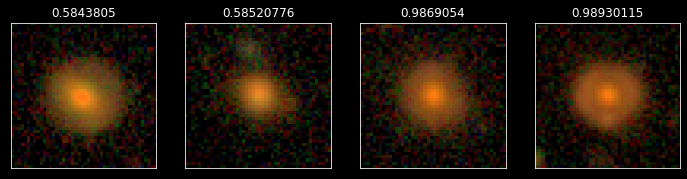

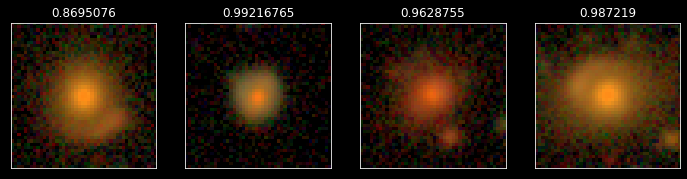

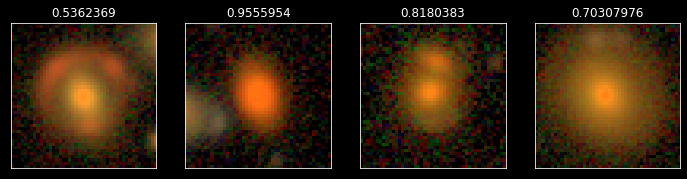

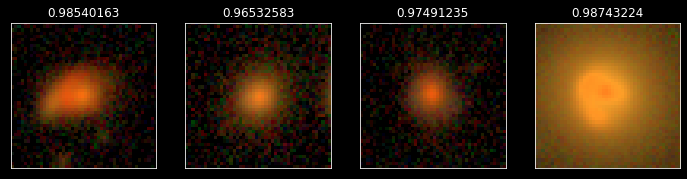

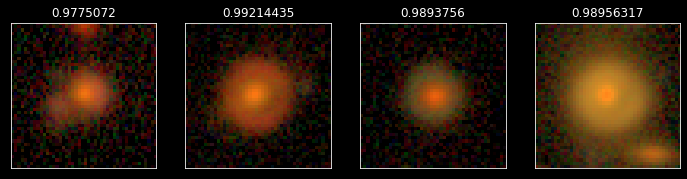

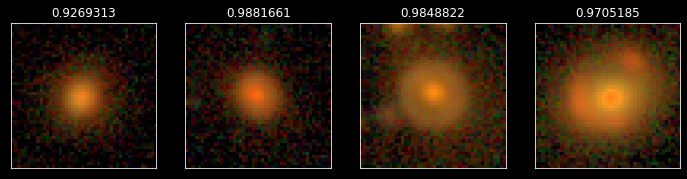

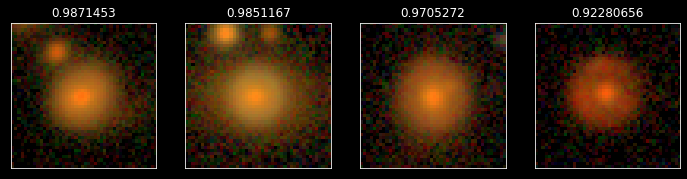

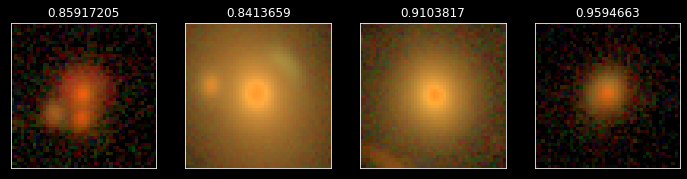

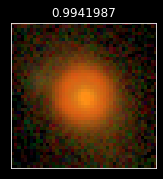

In [28]:
make_plot_all(right_pos_img, 'Right positives', right_pos['Prob'])

Right negatives


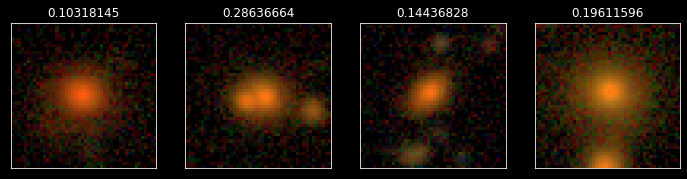

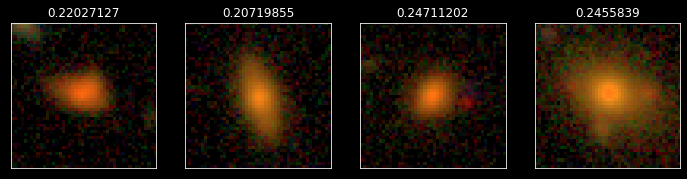

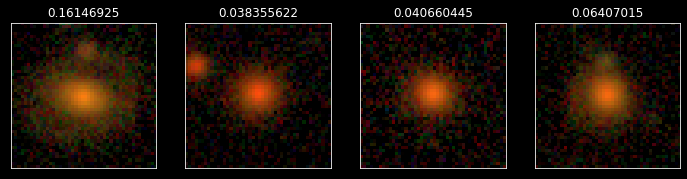

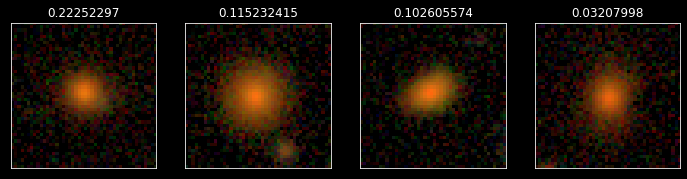

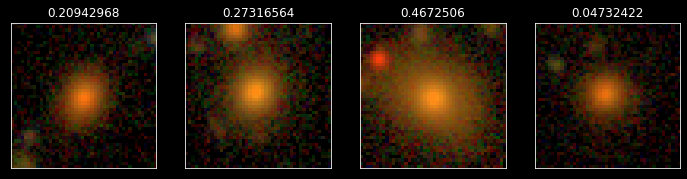

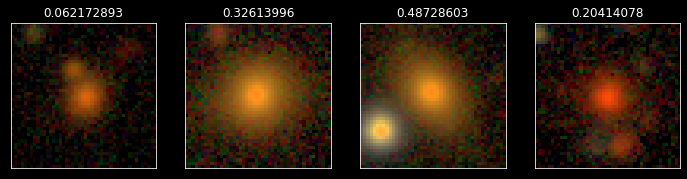

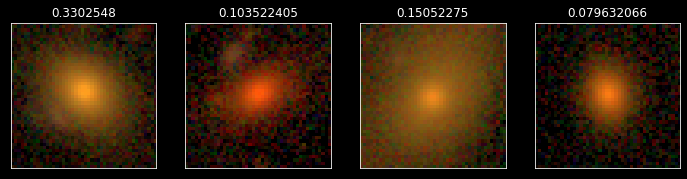

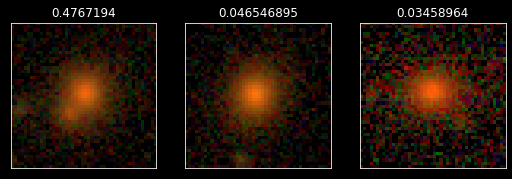

In [29]:
make_plot_all(right_neg_img, 'Right negatives', right_neg['Prob'])